In [111]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tensorflow.tensorboard.backend.event_processing import event_accumulator
from collections import defaultdict
import numpy as np

In [57]:
path = 'archive-2017-07-04/named_results/model.shortcutsL1.1e-06_shortcutsL1_final.0.01_shortcutsL1_steps.1000.0_'
collection_name = 'compressedHistograms'

In [68]:
ea = event_accumulator.EventAccumulator(path, #'example_results/events.out.tfevents.1496749144.L-E7-thalita'
                                        size_guidance={ # see below regarding this argument
                                        event_accumulator.COMPRESSED_HISTOGRAMS: 500,
                                        event_accumulator.IMAGES: 4,
                                        event_accumulator.AUDIO: 4,
                                        event_accumulator.SCALARS: 0,
                                        event_accumulator.HISTOGRAMS: 1,
                                         })
ea.Reload() # loads events from file
print(ea.Tags().keys())

INFO:tensorflow:No path found after archive-2017-07-04/named_results/model.shortcutsL1.1e-06_shortcutsL1_final.0.01_shortcutsL1_steps.1000.0_/events.out.tfevents.1499089616.sirocco01
dict_keys(['histograms', 'compressedHistograms', 'scalars', 'run_metadata', 'meta_graph', 'tensors', 'images', 'audio', 'graph'])


In [76]:
collection = ea.CompressedHistograms
event = collection('vgg_16/combfc7/w_l5_vgg_16/conv3/conv3_1/Relu_')
event

[CompressedHistogramEvent(wall_time=1499089638.867475, step=1, compressed_histogram_values=[CompressedHistogramValue(basis_point=0, value=0.0625), CompressedHistogramValue(basis_point=668, value=0.0625), CompressedHistogramValue(basis_point=1587, value=0.0625), CompressedHistogramValue(basis_point=3085, value=0.0625), CompressedHistogramValue(basis_point=5000, value=0.0625), CompressedHistogramValue(basis_point=6915, value=0.0625), CompressedHistogramValue(basis_point=8413, value=0.0625), CompressedHistogramValue(basis_point=9332, value=0.0625), CompressedHistogramValue(basis_point=10000, value=0.0625)]),
 CompressedHistogramEvent(wall_time=1499090067.7584536, step=501, compressed_histogram_values=[CompressedHistogramValue(basis_point=0, value=0.0075566330924630165), CompressedHistogramValue(basis_point=668, value=0.0075566330924630165), CompressedHistogramValue(basis_point=1587, value=0.0075566330924630165), CompressedHistogramValue(basis_point=3085, value=0.0075566330924630165), Comp

In [77]:
event[0]

CompressedHistogramEvent(wall_time=1499089638.867475, step=1, compressed_histogram_values=[CompressedHistogramValue(basis_point=0, value=0.0625), CompressedHistogramValue(basis_point=668, value=0.0625), CompressedHistogramValue(basis_point=1587, value=0.0625), CompressedHistogramValue(basis_point=3085, value=0.0625), CompressedHistogramValue(basis_point=5000, value=0.0625), CompressedHistogramValue(basis_point=6915, value=0.0625), CompressedHistogramValue(basis_point=8413, value=0.0625), CompressedHistogramValue(basis_point=9332, value=0.0625), CompressedHistogramValue(basis_point=10000, value=0.0625)])

In [74]:
len(event), len(event[0])

(42, 3)

In [72]:
event[0].compressed_histogram_values[0].value #it is a named_tuple

0.0625

In [81]:
name_func = 'comb'
values = defaultdict(list)
for function in ea.Tags()[collection_name]:
    if function.find(name_func) > -1: #to find an approximate name_func 
        for element in (collection(function)):
            values[function].append(element.compressed_histogram_values[0].value) 

## Graph viz with networkx

In [170]:
import networkx as nx

In [208]:
min_weight = 1e-3
G = nx.DiGraph()
for name, curve in values.items():
    weight = curve[-1]
    if weight > min_weight:
        parts = name.split('/')
        to = parts[1].strip('comb') + '_sum'
        if to.find('fc') > -1:
            to = parts[1].strip('comb').strip('fc') + '_fc_sum'
        if parts[3].find('conv') > -1:
            orig =  parts[4].strip('conv') + '_conv'
        elif parts[3].find('batch') > -1:
            orig = '0_input'
        else:
            orig = parts[3].strip('fc') + '_fc'

        G.add_edge(orig, to, weight=curve[-1])

Bellow are nodes in order and adjacency list. The x_x_sum nodes are the assembly points for all shortcuts, and are always connected to the next layer. These connections are ommited here because this graph is considering only the shortcut weights.

In [209]:
sorted(G.nodes())

['0_input',
 '1_1_conv',
 '1_1_sum',
 '1_2_conv',
 '1_2_sum',
 '2_1_conv',
 '2_1_sum',
 '2_2_conv',
 '2_2_sum',
 '3_1_conv',
 '3_3_sum',
 '4_1_conv',
 '4_3_sum',
 '5_1_conv',
 '5_1_sum',
 '5_2_conv',
 '5_2_sum',
 '5_3_conv',
 '5_3_sum',
 '6_fc',
 '7_fc_sum']

Adjacency dictionary `{from: {to: ...}, ...}`

In [210]:
G.adj 

{'0_input': {'1_1_sum': {'weight': 0.25644329190254211},
  '1_2_sum': {'weight': 0.10531949996948242},
  '2_1_sum': {'weight': 0.055624257773160934},
  '3_3_sum': {'weight': 0.0012694644974544644},
  '4_3_sum': {'weight': 0.019441047683358192},
  '7_fc_sum': {'weight': 0.0039797956123948097}},
 '1_1_conv': {'1_1_sum': {'weight': 0.32574537396430969},
  '1_2_sum': {'weight': 0.15524393320083618},
  '2_1_sum': {'weight': 0.052573099732398987},
  '2_2_sum': {'weight': 0.020204367116093636},
  '3_3_sum': {'weight': 0.046998612582683563},
  '4_3_sum': {'weight': 0.016662998124957085},
  '5_1_sum': {'weight': 0.075965054333209991},
  '5_2_sum': {'weight': 0.00915481336414814},
  '7_fc_sum': {'weight': 0.005873032845556736}},
 '1_1_sum': {},
 '1_2_conv': {'1_2_sum': {'weight': 0.34620606899261475},
  '2_1_sum': {'weight': 0.045290432870388031},
  '2_2_sum': {'weight': 0.018953492864966393},
  '3_3_sum': {'weight': 0.099464401602745056},
  '4_3_sum': {'weight': 0.10935822874307632},
  '5_1_sum

In [199]:
nodes = sorted(G.nodes())
shell = []
raid = []
start = nodes[0][0]
for n in nodes:
    if n[0] != start:
        start = n[0]
        shell.append(raid)
        raid = []
    raid.append(n)
shell.append(raid)


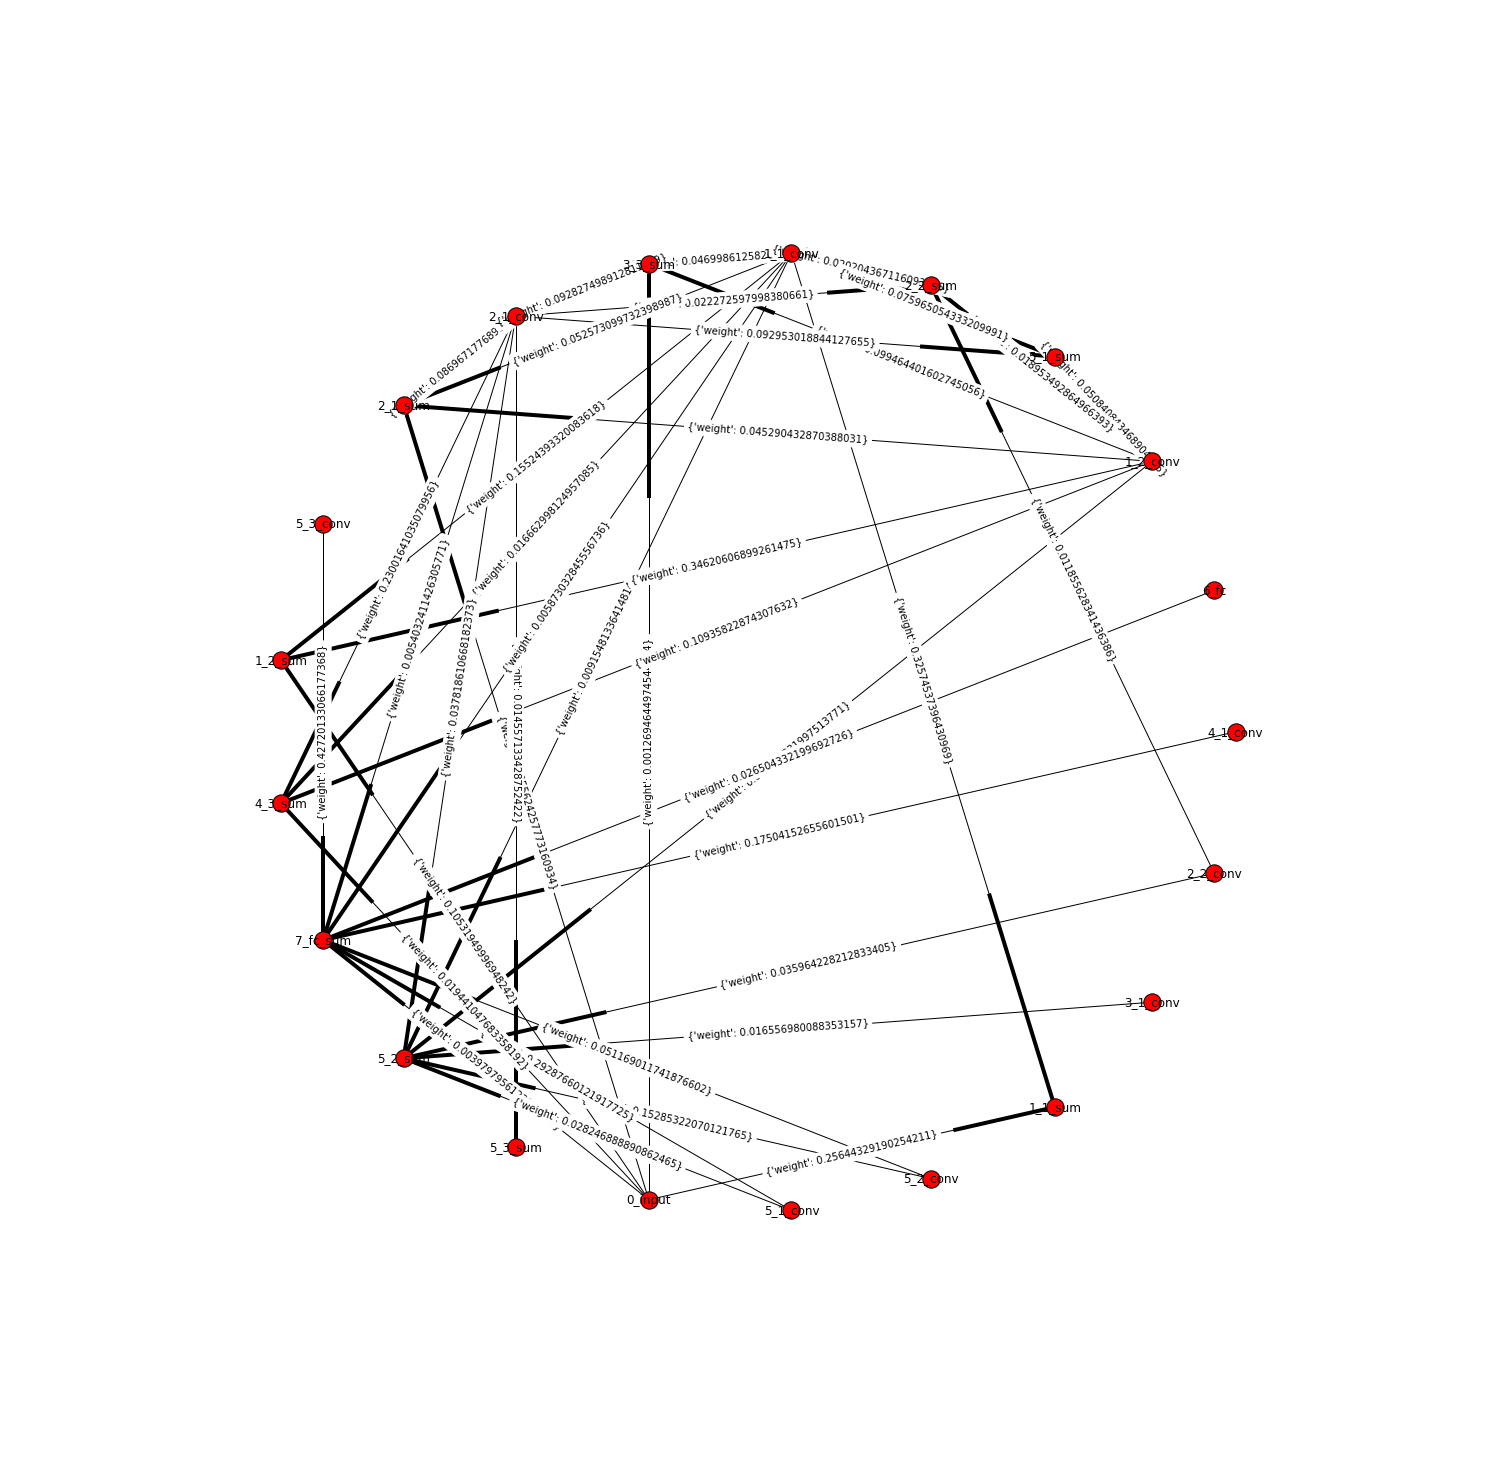

In [211]:
scale = 5
pos = np.array([[i*scale,i*scale] for i in range(len(G.nodes()))])
pos = dict(zip(sorted(G.nodes()), pos))

plt.figure(figsize=(20,20))
nx.draw(G, with_labels=True, pos=nx.circular_layout(G), edge_cmap='Blues', edge_vmin=0, edge_vmax=0.25)
nx.draw_networkx_edge_labels(G,nx.circular_layout(G));